# Required Imports And Initalization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Initalization

In [2]:
%%capture
!pip install evaluate==0.3.0
!pip install transformers==4.24.0
!pip install datasets==2.7.1

## Imports and Constants

In [3]:
import json
import os
import re
import numpy as np
from collections import defaultdict
from datetime import timedelta, datetime
from tqdm.autonotebook import tqdm

DATASET_PATH = 'drive/MyDrive/CS485/twitch_dataset/' # @param {type:"string"}
TRANSCRIPT_PATH = 'drive/MyDrive/CS485/twitch_dataset/transcripts_ninja/' # @param {type:"string"}
STREAM_JSON = 'streams_ninja_100.json' # @param {type:"string"}

TOP_20_NINJA: list[str] = [
    "LUL", "HUH", "KEKW", "ninjaCreep", "ninjaPower", "ninjaBlast2",
    "ninjaHype", "ninjaBlast3", "ninjaBlast1", "ninjaGnam", "ninjaCRINJA",
    "ninjaPog", "ninjaTroll", "ninjaH", "ninjaTooth", "<3", "ninja10",
    ":)", "ninjak", "ninjaTilted"
]
TOP_20_NINJA_lower = [word.lower() for word in TOP_20_NINJA]
TOP_20_NINJA_lower_set = set(TOP_20_NINJA_lower)

with open(os.path.join(DATASET_PATH, STREAM_JSON)) as f:
  STREAM_DICT = json.load(f)

<ipython-input-3-7991594f9506>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Preprocess Transcripts and Chat logs


In [ ]:
def tokenize_emote(doc: str, emotes: list):
  """Returns the number of emotes (as a dictionary) from the list of emotes"""
  bow = defaultdict(float)
  tokens = doc.split()
  for token in tokens:
    if token.lower() in emotes:
      if bow[token.lower()] != 1.0:
        bow[token.lower()] += 1.0
  return bow

Process Chat Logs

In [ ]:
streamers = []
all_emotes = defaultdict(list)
all_chat_timestamps = defaultdict(list)

for streamer, videos in STREAM_DICT.items():
  for video in videos:
    data_file = os.path.join(DATASET_PATH, f'{streamer}_{video}.txt')
    if not os.path.exists(data_file):
      print(f'skipping {data_file}, not found')
    else:
      # Open the data file and read its content
      with open(data_file, "r", encoding="utf8") as doc:
        # Iterate over each line in the file
        for chat_message in doc:
          # Extract the timestamp and message from the chat line
          time_stamp = chat_message[chat_message.find("[") + 1 : chat_message.find("]")]
          msg = chat_message[chat_message.find(":", 10) + 1 :]

          # Split the timestamp into hours, minutes, and seconds
          t = time_stamp.split(":")

          # Convert the timestamp to timedelta and add it to the list of chat timestamps
          all_chat_timestamps[f'{streamer}_{video}'].append(
              # using timedelta instead of datetime because it doesn't require date
              timedelta(hours=int(t[0]), minutes=int(t[1]), seconds=int(t[2]))
          )

          # Tokenize emotes from the message and add them to the list of emotes
          all_emotes[f'{streamer}_{video}'].append(tokenize_emote(msg, TOP_20_NINJA_lower_set))

Process Transcripts and Pair

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression, SGDRegressor
from sklearn.metrics import confusion_matrix
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
import json

transcript = {}
for streamer, videos in STREAM_DICT.items():
  for video in videos:
    transcript_file = os.path.join(TRANSCRIPT_PATH, f'{streamer}_{video}_transcript.json')
    if not os.path.exists(transcript_file):
      print(f'skipping {transcript_file}, not found')
    else:
      with open(transcript_file, 'r') as doc:
        transcript[f'{streamer}_{video}'] = json.load(doc)

skipping drive/MyDrive/CS485/twitch_dataset/transcripts_ninja/Ninja_1966676083_transcript.json, not found


Pair transcript to chat log

In [ ]:
all_data = {}
all_label = {}
for streamer in transcript:
    timestamps = all_chat_timestamps[streamer]
    emotes = all_emotes[streamer]

    data = []
    label = []
    last_timestamp_idx = 0
    for i, seg in enumerate(transcript[streamer]["segments"]):
        start = timedelta(seconds=seg["start"])
        end = timedelta(seconds=seg["end"])
        # add start, end, and text
        data.append((timedelta(seconds=seg["start"]), timedelta(seconds=seg["end"]), seg["text"]))
        label.append(defaultdict(float))

        last_timestamp_idx_cpy = last_timestamp_idx
        finding_stage= True # determines whether you should increment the timestamp
        # print(seg) # testing
        for j, emote in enumerate(emotes[last_timestamp_idx_cpy:]):
            # within 30 seconds of the timestamp
            if timestamps[j + last_timestamp_idx_cpy] >= start and timestamps[j + last_timestamp_idx_cpy] <= end + timedelta(seconds=30):
                # add the seen emotes to the transcript

                # # update is not correct
                # label[i].update(emote)

                # print(f'updating with {emote=}')
                for emoticon, value in emote.items():
                  label[i][emoticon] += value

                # don't add to the counter anymore
                finding_stage = False
            elif finding_stage:
              last_timestamp_idx += 1
            else: # gone too far, since sorted, nothing will be within 30s anymore
              break
    # add text
    all_data[streamer] = [d[2].strip() for d in data]
    # add label (dictionary)
    all_label[streamer] = label

# print(all_data)
# print(all_label)

In [ ]:
x = [text for streamer, text_list in all_data.items() for text in text_list]
tokens = [token_count for token_count_list in all_label.values() for token_count in token_count_list]

y = np.array([[token_count[emote] for emote in TOP_20_NINJA_lower] for token_count in tokens])

assert(len(x) == y.shape[0])

Filter out entries with no emotes

In [ ]:
input_pairs = [(text,emote_arr) for text,emote_arr in zip(x,y) if sum(emote_arr) != 0]
filtered_x = [pair[0] for pair in input_pairs]
filtered_y = np.array([np.argmax(pair[1]) for pair in input_pairs])

with open(os.path.join(DATASET_PATH, 'train_files/', 'x_ninja_100.json'), 'w+') as f:
  json.dump(filtered_x, f)
np.save(os.path.join(DATASET_PATH, 'train_files/', 'y_ninja_100.npy'), filtered_y)

In [ ]:
y_boe = np.array([pair[1] for pair in input_pairs])
agreement_label_rates = np.max(y_boe, axis = 1) / np.sum(y_boe, axis = 1)

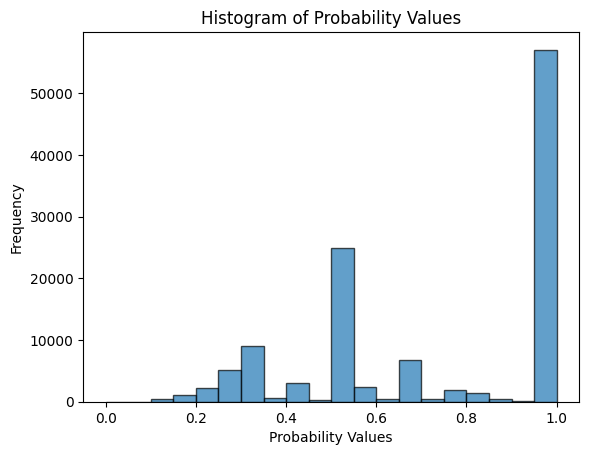

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a random dataset of probability values between 0 and 1
data = agreement_label_rates

# Define the bin edges with increments of 0.05
bins = np.arange(0, 1.05, 0.05)

# Create the histogram
plt.hist(data, bins=bins, edgecolor='black', alpha=0.7)

# Set labels and title
plt.xlabel('Probability Values')
plt.ylabel('Frequency')
plt.title('Histogram of Probability Values')

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


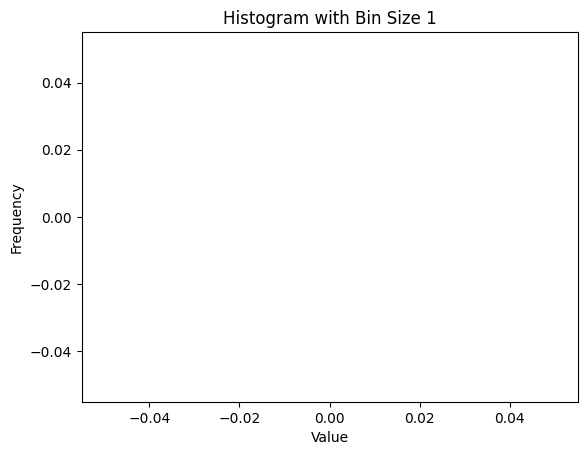

In [ ]:
def plot_histogram(data, bin_size):
    # Create histogram
    plt.hist(data, bins=np.arange(0j, 36, bin_size), edgecolor='black')

    # Set labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram with Bin Size {bin_size}')

    # Show the plot
    plt.show()


plot_histogram(np.max(y, axis=1), 1)

In [ ]:
a = [pair[1] for pair in input_pairs][0]
a

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0.])

In [ ]:
np.max(a) / np.sum(a)

0.3333333333333333

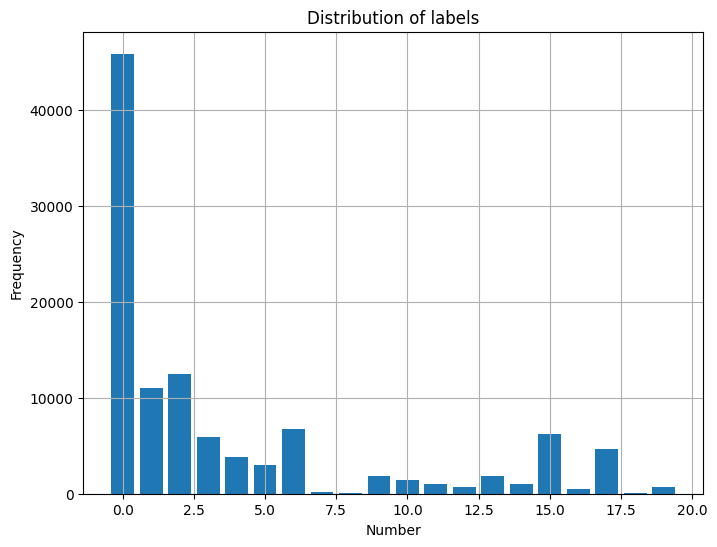

array([45857, 11018, 12522,  5889,  3831,  3011,  6735,   166,   125,
        1821,  1448,   962,   674,  1816,   976,  6232,   504,  4647,
          63,   713])

In [7]:
import matplotlib.pyplot as plt

# Count the occurrences of each number_
numbers, counts = np.unique(new_y, return_counts=True)
# numbers, counts = np.unique(y_train, return_counts=True)


# Create a bar chart
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.bar(numbers, counts)  # Plot the bars
plt.xlabel("Number")  # Set the x-axis label
plt.ylabel("Frequency")  # Set the y-axis label
plt.title("Distribution of labels")  # Set the title
plt.grid(True)  # Show the grid lines
plt.show()

counts

# Train the model

Training parameters

In [4]:
use_class_weights = False # @param {type:"boolean"}
user_under_over_sample = True # @param {type:"boolean"}
remove_redundant = True # @param {type:"boolean"}
NUM_EMOTES = 20

Optionally, load in saved data to skip preprocessing.

In [5]:
with open(os.path.join(DATASET_PATH, 'train_files/', 'x_ninja_100.json'), 'r') as f:
  new_x = json.load(f)

new_y = np.load(os.path.join(DATASET_PATH, 'train_files/', 'y_ninja_100.npy'))

Optionally, remove any redudant segments. During periods of silence, Whisper has a tendency to repeat segments, polluting the output.

In [6]:
trimmed_x = []
trimmed_y = []
last = 'djfjdjfdsflajsldfs'
for i, (x, y) in enumerate(zip(new_x, new_y)):
  if last == x:
    continue
  trimmed_x.append(x)
  trimmed_y.append(y)
  last = x

trimmed_y = np.array(trimmed_y)

print(f'Old data size: {len(new_x)}')
new_x = trimmed_x
new_y = trimmed_y
print(f'New data size: {len(new_x)}')

Old data size: 117574
New data size: 109010


In [7]:
import torch

class TwitchDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
    self.tokenizer = tokenizer

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

In [8]:
from collections import Counter
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(new_x, new_y, test_size=0.2, random_state=0)

weights = [0] * NUM_EMOTES
total = len(new_y)
for k,v in Counter(new_y).items():
  weights[k] = ((total/NUM_EMOTES) / v) # ideally, if the distribution is uniform, weights should be 1

Oversample/Undersample to best deal with emote discrepancies

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

numbers, counts = np.unique(y_train, return_counts=True)
median = int(np.median(counts))

X, y = X_train, y_train

under_sampler = RandomUnderSampler(sampling_strategy={label: min(median, counts[label]) for label in range(20)})

print({label: min(median, counts[label]) for label in range(20)})

X, y = under_sampler.fit_resample(np.array(X).reshape(-1,1), y)

numbers, counts = np.unique(y, return_counts=True)
print({label: max(median, counts[label]) for label in range(20)})

over_sampler = RandomOverSampler(sampling_strategy={label: max(median, counts[label]) for label in range(20)})
X, y = over_sampler.fit_resample(X, y)

# commit
X_train = list(X.flatten())
y_train = y

{0: 1300, 1: 1300, 2: 1300, 3: 1300, 4: 1300, 5: 1300, 6: 1300, 7: 76, 8: 75, 9: 1292, 10: 994, 11: 644, 12: 487, 13: 1300, 14: 605, 15: 1300, 16: 272, 17: 1300, 18: 43, 19: 366}
{0: 1300, 1: 1300, 2: 1300, 3: 1300, 4: 1300, 5: 1300, 6: 1300, 7: 1300, 8: 1300, 9: 1300, 10: 1300, 11: 1300, 12: 1300, 13: 1300, 14: 1300, 15: 1300, 16: 1300, 17: 1300, 18: 1300, 19: 1300}


Optionally, just undersample the most frequent class to reduce training time

In [9]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# get second most frequent
numbers, counts = np.unique(y_train, return_counts=True)

second_highest = np.sort(counts)[-2]

X, y = X_train, y_train

under_sampler = RandomUnderSampler(sampling_strategy={label: min(second_highest, counts[label]) for label in range(20)})

X, y = under_sampler.fit_resample(np.array(X).reshape(-1,1), y)

# commit
X_train = list(X.flatten())
y_train = y

In [10]:
from torch import nn
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        if use_class_weights:
          loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device)) # balance weights proportional to the inverse of the frequency, divided by the
        else:
          loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0] * NUM_EMOTES, device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [12]:
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy

# pretrained_bert = 'roberta-base'
# pretrained_bert = 'roberta-large'
pretrained_bert = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(pretrained_bert)


# Source: https://huggingface.co/transformers/training.html
import evaluate

# metric = evaluate.combine(['accuracy', 'recall', 'precision', 'f1'])

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = numpy.argmax(logits, axis=-1)
  # Accuracy
  accuracy = accuracy_score(labels, predictions)

  # Precision
  precision = precision_score(labels, predictions, average='macro')

  # Recall
  recall = recall_score(labels, predictions, average='macro')

  # F1 score
  f1 = f1_score(labels, predictions, average='macro')

  print(predictions[:10])

  return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

from transformers import AutoModelForSequenceClassification

def model_init():
  return AutoModelForSequenceClassification.from_pretrained(
    pretrained_bert, num_labels=NUM_EMOTES)

from transformers import TrainingArguments

train_encodings = tokenizer(X_train, truncation=True)
train_dataset = TwitchDataset(train_encodings, y_train)
val_encodings = tokenizer(X_val, truncation=True)
val_dataset = TwitchDataset(val_encodings, y_val)

training_args = TrainingArguments(
    output_dir='./results',         # output directory
    num_train_epochs=3,             # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=8,  # batch size for evaluation
    evaluation_strategy="epoch",    # evaluation occurs after each epoch
    # logging_dir='./logs',           # directory for storing logs
    logging_strategy="epoch",       # logging occurs after each epoch
    log_level="error",            # set logging level
    optim="adamw_torch",            # use pytorch's adamw implementation
    learning_rate=5e-5,
    # learning_rate=1e-3,
    save_steps=50000,
    seed=666,
    # weight_decay=1e-3
)

trainer = CustomTrainer(
    model_init=model_init,            # method instantiates model to be trained
    args=training_args,               # training arguments, defined above
    train_dataset=train_dataset,      # training dataset
    eval_dataset=val_dataset,         # evaluation dataset
    compute_metrics=compute_metrics,  # function to be used in evaluation
    tokenizer=tokenizer,              # enable dynamic padding
)

trainer.train()
val_accuracy = trainer.evaluate()['eval_accuracy']

print()
print()
print(f"FINAL: Validation Accuracy {val_accuracy}")

{'loss': 2.4689, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0 2 0 0 0 0 2 2 0 0]
{'eval_loss': 2.2446255683898926, 'eval_accuracy': 0.27125951747546095, 'eval_precision': 0.06772780439147985, 'eval_recall': 0.053906425700195125, 'eval_f1': 0.038582221890504975, 'eval_runtime': 23.0377, 'eval_samples_per_second': 946.364, 'eval_steps_per_second': 118.328, 'epoch': 1.0}
{'loss': 2.4183, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[2 1 0 0 0 0 2 2 0 2]
{'eval_loss': 2.2441346645355225, 'eval_accuracy': 0.21695257315842584, 'eval_precision': 0.08241121445334701, 'eval_recall': 0.060922925902808324, 'eval_f1': 0.04780336869611819, 'eval_runtime': 23.6192, 'eval_samples_per_second': 923.061, 'eval_steps_per_second': 115.414, 'epoch': 2.0}
{'loss': 2.3018, 'learning_rate': 0.0, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[2 1 0 0 1 6 2 2 0 1]
{'eval_loss': 2.2941219806671143, 'eval_accuracy': 0.22328226768186404, 'eval_precision': 0.0720057377895163, 'eval_recall': 0.06424054709304416, 'eval_f1': 0.055707065693956295, 'eval_runtime': 22.7783, 'eval_samples_per_second': 957.14, 'eval_steps_per_second': 119.675, 'epoch': 3.0}
{'train_runtime': 650.4383, 'train_samples_per_second': 279.264, 'train_steps_per_second': 8.731, 'train_loss': 2.396323678106841, 'epoch': 3.0}
[2 1 0 0 1 6 2 2 0 1]
{'eval_loss': 2.2941219806671143, 'eval_accuracy': 0.22328226768186404, 'eval_precision': 0.0720057377895163, 'eval_recall': 0.06424054709304416, 'eval_f1': 0.055707065693956295, 'eval_runtime': 22.8239, 'eval_samples_per_second': 955.227, 'eval_steps_per_second': 119.436, 'epoch': 3.0}


FINAL: Validation Accuracy 0.22328226768186404


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I am definitely writing code Google, no need to kick me out. Training these models actually sucks so much. i really hate training these. I feel so sick. Like riddiculously sick
please don't boot me out google

So far the best is roughly 6 iterations with 9.17% accuracy. Will be useful to see what it's predicting. Will run up until 20 iterations, but so far hte trend really seems to be train low.

HOLY POOP 48.8% ACCURACY AT 18 ITERATIONSd

This is almost certianly just predicting the most common class really well, and is spiking the accuracy. Nonetheless, impressive.

Get the predictions from the validation set

In [14]:
prediction_tuples = trainer.predict(val_dataset)
list(np.argmax(prediction_tuples.predictions, axis=1))
# predcition_tuples.predictions jdkfjd fadsfjasldkf;askdfj sdjkafl;asefjasldfadf
# predcition_tuples.label_ids

[2 1 0 0 1 6 2 2 0 1]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[2,
 1,
 0,
 0,
 1,
 6,
 2,
 2,
 0,
 1,
 15,
 3,
 1,
 0,
 1,
 0,
 3,
 1,
 6,
 1,
 2,
 0,
 0,
 0,
 17,
 1,
 0,
 0,
 2,
 0,
 15,
 2,
 6,
 2,
 0,
 2,
 0,
 0,
 1,
 1,
 15,
 0,
 0,
 15,
 2,
 15,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 0,
 2,
 17,
 1,
 3,
 6,
 6,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 15,
 2,
 1,
 0,
 2,
 0,
 6,
 0,
 1,
 2,
 2,
 3,
 1,
 1,
 2,
 15,
 1,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 15,
 15,
 2,
 2,
 1,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 0,
 3,
 1,
 2,
 2,
 0,
 2,
 1,
 6,
 1,
 1,
 2,
 15,
 15,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 2,
 0,
 0,
 15,
 0,
 2,
 1,
 2,
 2,
 2,
 0,
 3,
 0,
 2,
 0,
 1,
 2,
 2,
 2,
 0,
 6,
 0,
 2,
 1,
 15,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 1,
 0,
 2,
 0,
 4,
 0,
 15,
 1,
 3,
 0,
 0,
 15,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 15,
 15,
 3,
 3,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 6,
 17,
 0,
 2,
 0,
 2,
 3,
 0,
 1,
 6,
 2,
 0,
 0,
 0,
 1,
 4,
 0,
 2,
 3,
 0,
 0,
 15,
 0,
 2,
 0,
 6,
 2,
 3,
 2,
 6,
 0,
 2,
 0,
 1,
 0,
 2,
 2,

Try a BoW model because these higher dimensionality ones aren't really cutting it

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# # Define your list of sentences and labels
# sentences = ["This movie was amazing!", "The food was terrible.", "I had a great day today.", "The meeting was boring."]
# labels = ["positive", "negative", "positive", "negative"]

# Tokenize and create bag-of-words feature vectors
vectorizer = CountVectorizer()
features = vectorizer.fit_transform(new_x)
labels = new_y

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [ ]:
# Train a multiclass Logistic Regression model
class_weights = {i: 1 for i in range(20)}
class_weights[0] = 0.01

model = LogisticRegression(class_weight=class_weights, max_iter=2000)
model.fit(X_train, y_train)

# Predict classes for the test set
y_predicted = model.predict(X_test)

# Evaluate performance (accuracy)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_predicted)

# Precision
precision = precision_score(y_test, y_predicted, average='macro')

# Recall
recall = recall_score(y_test, y_predicted, average='macro')

# F1 score
f1 = f1_score(y_test, y_predicted, average='macro')

print(f'{accuracy=} {precision=} {recall=} {f1=}')

accuracy=0.11595266489312907 precision=0.05168684423378998 recall=0.06439649661431232 f1=0.043681063274404366


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


See predictions

In [ ]:
analysis_texts = [
    "That's for extra ketchup at BK."
    'I told my doctor that I broke my arm in two places – he told me to stop going to those places.',
    'Evening news is where they begin with “Good evening,” and then proceed to tell you why it isn’t.',
    'How did the hipster burn his mouth? He ate his pizza before it was cool.',
    'Thanks so much for the gift last night!',
    'I keep losing, can I please win a game?',
    'So anyways, the cashier kept talking to me at the store, and asking me how my day ways, and I was like: stop dude.',
    'I hate this game so much.',
    'What is jdkfjkdfjdkf dsllslsl sllsll',
]

analysis_encodings = tokenizer(analysis_texts, truncation=True)
analysis_dataset = TwitchDataset(analysis_encodings, [[0] for i in range(len(analysis_texts))])

trainer.predict(analysis_dataset)

# Basic Models


In [ ]:
from transformers import AutoTokenizer, BertModel
import torch
import numpy
pretrained_bert = 'bert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(pretrained_bert)
model = BertModel.from_pretrained(pretrained_bert,
                                  output_hidden_states=True).to(device)

def extract_bert_features(input_texts):
  features = []
  for i, text in enumerate(tqdm(input_texts)):
    input = tokenizer.encode(text, truncation=True,
                             return_tensors="pt").to(device)
    hidden_states = model(input).hidden_states
    feature = torch.stack(hidden_states)[1:, :, 0, :].reshape((12,768)).detach().cpu().numpy()

    assert feature.shape == (12, 768)
    features.append(feature)

  return numpy.stack(features)

embeddings = extract_bert_features(new_x)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/109010 [00:00<?, ?it/s]

In [ ]:
np.save(os.path.join(DATASET_PATH, 'train_files/', 'x_ninja_100_embeddings.npy'), embeddings)
np.save(os.path.join(DATASET_PATH, 'train_files/', 'y_ninja_100_embeddings.npy'), new_y)

In [ ]:
embeddings = np.load(os.path.join(DATASET_PATH, 'train_files/', 'x_ninja_100_embeddings.npy'))
new_y = np.load(os.path.join(DATASET_PATH, 'train_files/', 'y_ninja_100_embeddings.npy'))

In [ ]:
np.unique(new_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# get second most frequent
# print('i here')
# numbers, counts = np.unique(new_y, return_counts=True)
flat_embed = embeddings[:, 0, :].reshape(embeddings.shape[0], -1)
print('obtained counnts')
under_sampler = RandomUnderSampler(sampling_strategy={label: 50 if label < 5 else 0 for label in range(20)})
print('undersampling')
X, y = under_sampler.fit_resample(flat_embed, new_y)

# # commit
# X_train = list(X.flatten())
# y_train = y
print(X.shape)
print(y.shape)

obtained counnts
undersampling
(250, 768)
(250,)


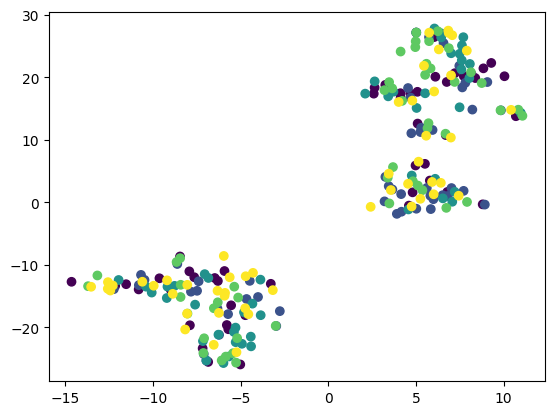

In [ ]:
# from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# from tsnecuda import TSNE

# Create the TSNE model
tsne = TSNE(n_components=2)
# tsne = PCA(n_components=2)

# Transform the data
tsne_data = tsne.fit_transform(X
                               )

# Plot the data with color encoding for labels
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=y)
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

X_embed_train, X_embed_val, y_train, y_val = train_test_split(embeddings[:, 0, :].reshape(embeddings.shape[0], -1), new_y, test_size=0.2, random_state=0)

# get second most frequent
numbers, counts = np.unique(y_train, return_counts=True)

second_highest = np.sort(counts)[-2]

X, y = X_embed_train, y_train

under_sampler = RandomUnderSampler(sampling_strategy={label: min(second_highest, counts[label]) for label in range(20)})

X, y = under_sampler.fit_resample(np.array(X), y)

print(X.shape)

# commit
X_embed_train = X
y_train = y

# r = LogisticRegression(max_iter = 4000, verbose=1)
r = MLPClassifier(hidden_layer_sizes=(128,128), max_iter=50)
# r = RandomForestClassifier(class_weight = 'balanced', verbose=1)
r.fit(X_embed_train, y_train)

pred = r.predict(X_embed_val)

r.score(X_embed_val, y_val)

(52887, 768)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


0.2582331896156316

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(pred, y_val)
# cohen_kappa_score(np.argmax(prediction_tuples.predictions, axis=1), y_val)

In [ ]:
from collections import Counter
Counter(new_y)

In [ ]:
!pip install firthlogist

In [ ]:
from firthlogist import FirthLogisticRegression
fl = FirthLogisticRegression()
fl.fit(X_embed_train, y_train)

In [ ]:
new_x

In [ ]:
new_y

In [4]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

--2023-12-16 02:59:12--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2023-12-16 02:59:12--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.01MB/s    in 4m 44s  

2023-12-16 03:03:56 (5.10 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [5]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [8]:
# code to load the model taken from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

def normalize(arrs):
    return [arr/(sum(arr ** 2) ** 0.5 if sum(arr ** 2) ** 0.5 != 0 else 1e10) for arr in arrs]

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
token_x = [word_tokenize(sentence) for sentence in new_x]

# Load the pre-trained GloVe model
model = load_glove_model('glove.twitter.27B.200d.txt')

# Create a list of word embeddings
word_embeddings = []
for sentence_tokens in token_x:
    sentence_embedding = np.zeros(200)
    for token in sentence_tokens:
        if token in model:
            sentence_embedding += model[token]
    sentence_embedding /= max(len(sentence_tokens), 1)
    word_embeddings.append(sentence_embedding)

glove_embeddings = normalize(word_embeddings)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Loading Glove Model
1193514 words loaded!


In [18]:
# from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_embed_train, X_embed_val, y_train, y_val = train_test_split(glove_embeddings, new_y, test_size=0.2, random_state=0)

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# get second most frequent
numbers, counts = np.unique(y_train, return_counts=True)

second_highest = np.sort(counts)[-2]

X, y = np.array(X_embed_train), y_train

under_sampler = RandomUnderSampler(sampling_strategy={label: min(second_highest, counts[label]) for label in range(20)})

X, y = under_sampler.fit_resample(X, y)

# commit
X_embed_train = X
y_train = y

r = LogisticRegression(max_iter = 10000)
# r = RandomForestClassifier(class_weight = 'balanced')
r.fit(X_embed_train, y_train)

pred = r.predict(X_embed_val)

r.score(X_embed_val, y_val)

0.2516282909824787

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  # Accuracy
  accuracy = accuracy_score(labels, predictions)

  # Precision
  precision = precision_score(labels, predictions, average='macro')

  # Recall
  recall = recall_score(labels, predictions, average='macro')

  # F1 score
  f1 = f1_score(labels, predictions, average='macro')

  print(predictions[:10])

  return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

compute_metrics((pred, y_val))

[0 1 0 2 1 0 2 2 0 2]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.2516282909824787,
 'precision': 0.04139643999583417,
 'recall': 0.05441994382109413,
 'f1': 0.039518733232672146}

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(pred, y_val)
# cohen_kappa_score(np.argmax(prediction_tuples.predictions, axis=1), y_val)

<ipython-input-15-0db444404703>:20: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


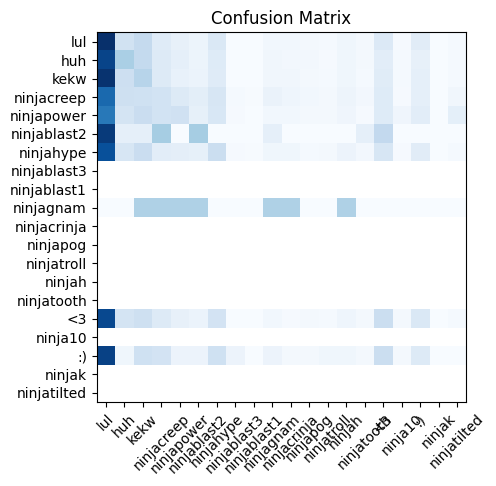

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot a confusion matrix.

    Args:
        y_true (array): The true labels.
        y_pred (array): The predicted labels.
        classes (list): The list of classes.

    Returns:
        None
    """
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    ax.imshow(cm_norm, interpolation='nearest', cmap=plt.get_cmap('Blues'))

    # Set the labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Set the title
    plt.title('Confusion Matrix')

    # # Set the colorbar
    # plt.colorbar()

    # Show the plot
    plt.show()
plot_confusion_matrix(np.argmax(prediction_tuples.predictions, axis=1), y_val, classes = TOP_20_NINJA_lower)
# plot_confusion_matrix(y_predicted, y_test, classes = TOP_20_NINJA_lower)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

precision_score(pred, y_val, average='micro')

0.2632785982937345